# Fit with analytical lens light

__last update__: 9/12/21

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import time
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from copy import deepcopy
import powerbox as pbox
from astropy.io import fits
from matplotlib.colors import LogNorm, TwoSlopeNorm
%matplotlib inline
plt.rc('image', interpolation='none')

import jax.numpy as jnp

from herculens.Instrument.psf import PSF
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import param_util, model_util, molet_util

## Global settings

In [2]:
# Choice of seeing conditions
psf_type = 'gaussian'  # 'gaussian', 'HST'
# Warning: 'HST' will take more time as convolutions are performed in real space... for now.

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=18, flux_vmin=1e-1, flux_vmax=2e1, res_vmax=4)

## Simulate the mock data

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [3]:
molet_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/wavelet-lensing-papers/paper_II/molet'
molet_simu_name = f'molet_sim_lens_only'
if psf_type == 'gaussian':
    molet_instru_name = 'gaussian03'
else:
    raise NotImplementedError("MOLET sims with non-gaussian PSFs have not been generated yet.")
    
pixel_grid, noise, psf_molet, data, psi_grid_input, noise_real, _, _ \
    = molet_util.read_molet_simulation(molet_dir, molet_simu_name,
                                       use_true_noise_map=False, 
                                       subtract_offset=True,
                                       cut_psf=20)

npix, npix_y = pixel_grid.num_pixel_axes
pix_scl = pixel_grid.pixel_width  # arcsec / pixel
xgrid, ygrid = pixel_grid.pixel_coordinates

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")
print(f"exposure time : {noise.exposure_map} s")
print(f"background noise level : {noise.background_rms:.3f}")

image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec
exposure time : 9600.0 s
background noise level : 0.005


/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:22: UserWarning: Using MOLET instrument 'gaussian03'.
  warnings.warn(f"Using MOLET instrument '{instrument_name}'.")
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:129: UserWarning: Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).
  warnings.warn("Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).")


### Point spread function

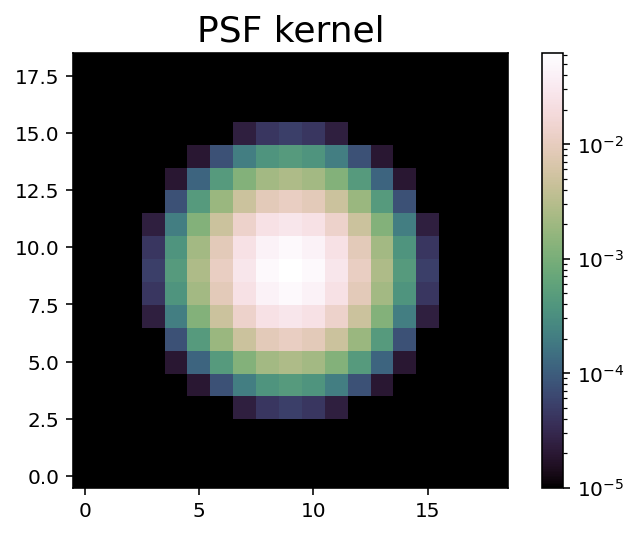

In [4]:
# PSF
if psf_type == 'gaussian':
    # Gaussian PSF
    psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, truncation=5, pixel_size=pix_scl)
    convolution_type = None  # ignored when using gaussian PSF (blurring performed through fast gaussian filtering)
elif psf_type == 'HST':
    # PSF from HST F160W
    psf_kernel = fits.getdata(os.path.join('data', 'PSF_HST_F160W_tinytim.fits'), header=False)
    psf_kernel = psf_kernel[25:-25, 25:-25] # trim it a bit so convolutions are faster
    psf_kernel /= psf_kernel.sum()
    print(psf_kernel.shape, psf_kernel.sum())
    psf = PSF(psf_type='PIXEL', kernel_point_source=psf_kernel)
    convolution_type = 'grid'
plt.figure()
plt.title("PSF kernel", fontsize=18)
plt.imshow(psf.kernel_point_source, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm(1e-5))
plt.colorbar()
plt.show()

### Mass and light models

In [22]:
# Fitted lens mass model
lens_mass_model_fit = LensModel([])

# Input source model 
source_model_fit = LightModel([])

# Input lens light
lens_light_model_fit = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 20.0, 'R_sersic': 2., 'n_sersic': 2., 
     'e1': 0.15, 'e2': -0.04, 
     'center_x': 0., 'center_y': 0.}
]

### Image model classes, for both simulate and fit

In [23]:
kwargs_numerics = {'supersampling_factor': 1, 'convolution_type': convolution_type}

# Hybrid image model for fitting
lens_image_fit = LensImage(pixel_grid, psf, noise_class=noise,
                                lens_model_class=lens_mass_model_fit,
                                source_model_class=source_model_fit,
                                lens_light_model_class=lens_light_model_fit,
                                kwargs_numerics=kwargs_numerics)

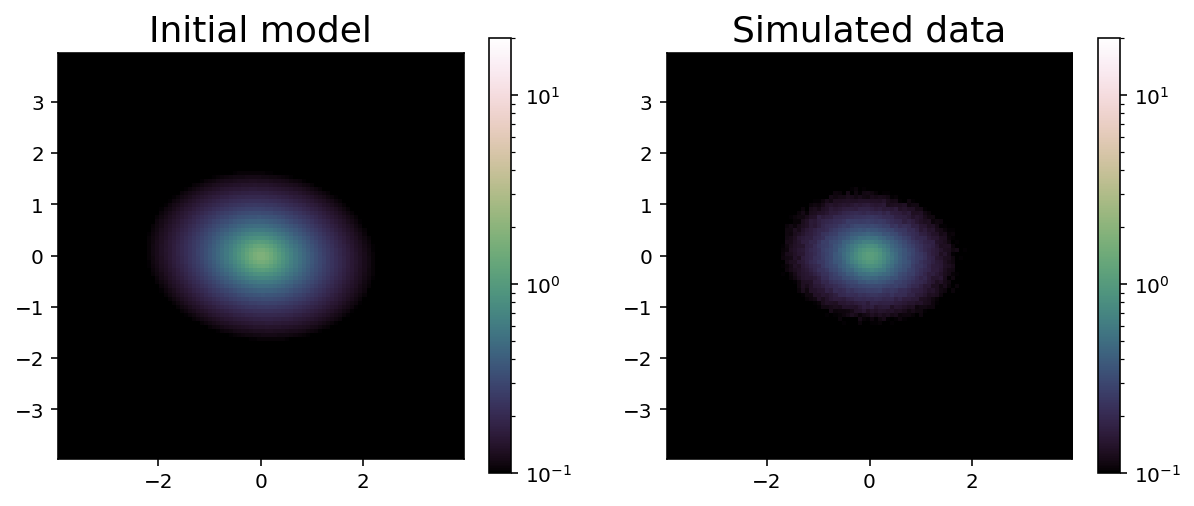

In [24]:
# Generate a lensed image based on source and lens models
initial_model = lens_image_fit.model(kwargs_lens_light=kwargs_lens_light_input)

# inform the plotter for later
plotter.set_data(data)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.set_title("Initial model", fontsize=18)
im = ax.imshow(initial_model, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[1]
ax.set_title("Simulated data", fontsize=18)
im = ax.imshow(data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
plt.show()

## Model fitting

### Prepare the parameters (initial values, constraints, etc.)

In [25]:
kwargs_init = {
    'kwargs_lens': [{}],
    'kwargs_source': [{}],
    'kwargs_lens_light': kwargs_lens_light_input,
}
kwargs_fixed = {
    'kwargs_lens': [{}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters = Parameters(lens_image_fit, kwargs_init, kwargs_fixed)
print("Number of fitted parameters:", parameters.num_parameters)

Number of fitted parameters: 7


### Fit source and macro lens model (if required)

In [26]:
# Create loss
loss_smooth_fit = Loss(data, lens_image_fit, parameters, 
                            likelihood_type='chi2', prior_terms=None)
print("Initial loss:", loss_smooth_fit(parameters.kwargs2args(kwargs_init)))
print("Number of data points in likelihood:", loss_smooth_fit.likelihood_num_data_points)

# Optimizer
optimizer_smooth_fit = Optimizer(loss_smooth_fit, parameters)
best_fit, logL, extra_fields, runtime \
    = optimizer_smooth_fit.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_smooth_fit(best_fit))
kwargs_smooth_fit = deepcopy(parameters.best_fit_values(as_kwargs=True))

Initial loss: 237814.95
Number of data points in likelihood: 10000
Runtime: 2.080176830291748
Loss at best-fit: 4944.462


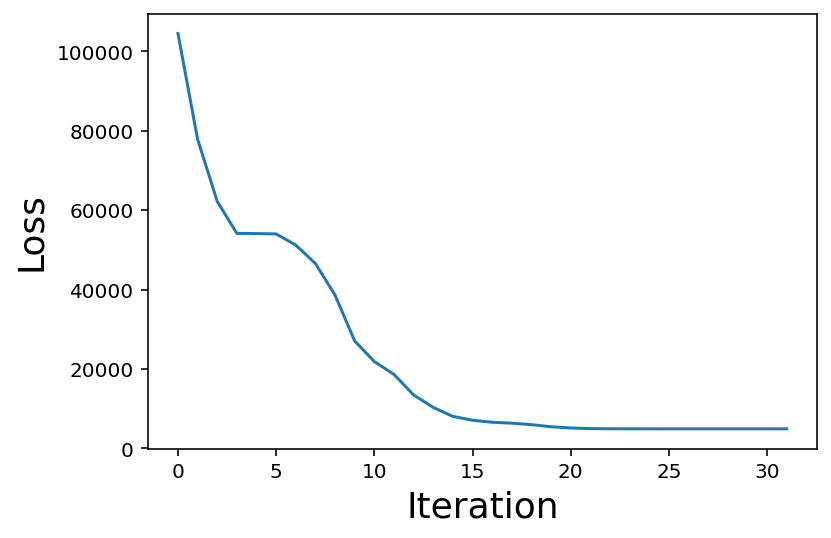

In [27]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

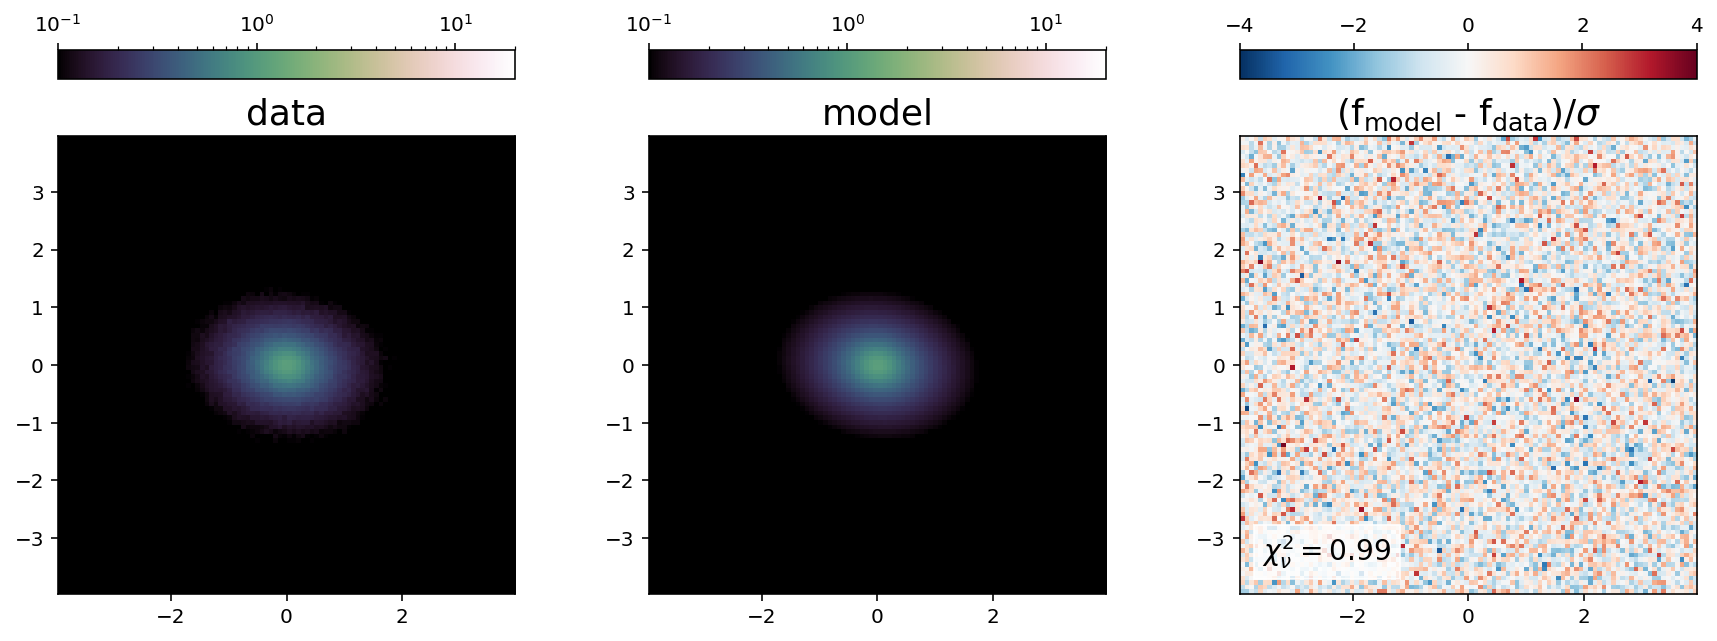

In [28]:
fig = plotter.model_summary(lens_image_fit, kwargs_smooth_fit, show_source=False)
plt.show()

In [29]:
pprint(kwargs_smooth_fit)

{'kwargs_lens': [],
 'kwargs_lens_light': [{'R_sersic': array(1.9949292, dtype=float32),
                        'amp': array(12.620034, dtype=float32),
                        'center_x': array(-0.00385393, dtype=float32),
                        'center_y': array(-0.00458917, dtype=float32),
                        'e1': array(0.14911005, dtype=float32),
                        'e2': array(-0.04016396, dtype=float32),
                        'n_sersic': array(1.9948864, dtype=float32)}],
 'kwargs_source': []}
